## Loading packages

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.misc import derivative
from IPython.display import clear_output
import scipy.integrate as integrate

## Random sampling from various distributions

In [11]:
def bernoulli(size,cplx=True):
    if cplx: 
        return ((2*np.random.binomial(1,.5,size=size)-1)+1j*(2*np.random.binomial(1,.5,size=size)-1))/np.sqrt(2)
    else:
        return (2*np.random.binomial(1,.5,size=size)-1)
def laplace(size,cplx=True):
    if cplx: 
        return (np.random.laplace(size=size)+1j*np.random.laplace(size=size))/2
    else:
        return np.random.laplace(size=size)/np.sqrt(2)
def normal(size,cplx=True):
    if cplx: 
        return (np.random.normal(size=size)+1j*np.random.normal(size=size))/np.sqrt(2)
    else:
        return np.random.normal(size=size)
def gennormal(size,beta=2,cplx=True):
    if cplx: 
        return (gennorm.rvs(beta, size=size)*np.sqrt(gamma(1/beta)/gamma(3/beta))+1j*gennorm.rvs(beta, size=size)*np.sqrt(gamma(1/beta)/gamma(3/beta)))/np.sqrt(2)
    else:
        return gennorm.rvs(beta, size=size)*np.sqrt(gamma(1/beta)/gamma(3/beta))
def halfnormal(size,cplx=True):
    return gennormal(size,beta=.5,cplx=cplx)
def quarternormal(size,cplx=True):
    return gennormal(size,beta=.25,cplx=cplx)

## Multi-Layer NN class

In [12]:
class multiLayerNLRM():
    def __init__(self,n0,n1,m,f=lambda x: x,cplx=True,dist=normal,sigmax=1,sigmaw=1,sigmab=0,layers=1,batchNorm=False):
        self.n0 = n0
        self.n1 = n1
        self.m = m
        self.Ws = sigmaw*dist(size=(n1,n0),cplx=cplx)
        self.Xs = sigmax*dist(size=(n0,m),cplx=cplx)
        self.Bs = np.tile(sigmab*dist(size=(n1,1),cplx=cplx),m)
        self.Zs = self.Ws@self.Xs/np.sqrt(self.n0)+self.Bs
        self.Ys = f(self.Zs)
        for k in range(layers-1):
            Ws = sigmaw*dist(size=(n1,n1),cplx=cplx)
            Bs = np.tile(sigmab*dist(size=(n1,1),cplx=cplx),m)
            Zs = Ws@self.Ys/np.sqrt(self.n1)+Bs
            self.Ys=f(Zs)
            if batchNorm:
                self.Ys=self.Ys/self.Ys.std(axis=0)
        self.Ms = np.matmul( self.Ys, self.Ys.T.conjugate() )/self.m
        self.eigs = np.linalg.eigh(self.Ms)[0]

## Computation of $\theta_{1},\theta_{1_b},\theta_{2}$ and solving quartic equation

In [13]:
def gcomp(z,theta1,theta2,phi,psi,cubic=False):
    coefs=[-z**2.*theta1*theta2*phi**2+z**2.*theta2**2.*phi**2,
           -2*z*theta1*theta2*phi**2+ 2.*z*theta2**2.*phi**2
               -z**2.*theta2*phi*psi+2.*z*theta1*theta2*phi*psi
               -2*z*theta2**2.*phi*psi,
           -theta1*theta2*phi**2+theta2**2.*phi**2
               -2*z*theta2*phi*psi+2.*theta1*theta2*phi*psi
               -2*theta2**2.*phi*psi+z*theta2*psi**2
               -theta1*theta2*psi**2+theta2**2.*psi**2
               +z*theta1*phi*psi**2,
           -theta2*phi*psi+theta2*psi**2+theta1*phi*psi**2
               +z*psi**3-theta1*psi**3,
           psi**3]
    if cubic:
        return np.roots(coefs[1:])
    else:
        return np.roots(coefs)
def gMP(z,chi,sx=1):
    coefs=[z*chi*sx**2,z-sx**2+chi*sx**2,1]
    return np.roots(coefs)
def theta1(f,vw=1,vx=1,vb=1):
    return integrate.quad(lambda x: f(np.sqrt(vw*vx+vb)*x)**2*np.exp(-x**2./2)/np.sqrt(2*np.pi),-np.inf,np.inf)[0]
def theta1b(f,vw=1,vx=1,vb=1):
    return integrate.dblquad(lambda x1,x2: f(x1)*f(x2)*
                         np.exp(-((vw*vx+vb)*(x1**2.+x2**2.)-2*vb*x1*x2)/
                                (2*vx*vw*(vx*vw+2*vb)))*
                          1/(2*np.pi*np.sqrt(vx*vw*(vx*vw+2*vb))),
                         -np.inf,np.inf,
                         lambda t: -np.inf,lambda t:np.inf)[0]
def theta2(df,vw=1,vx=1,vb=1):
    return integrate.dblquad(lambda x1,x2: df(x1)*df(x2)*
                         np.exp(-((vw*vx+vb)*(x1**2.+x2**2.)-2*vb*x1*x2)/
                                (2*vx*vw*(vx*vw+2*vb)))*
                         vx*vw/(2*np.pi*np.sqrt(vx*vw*(vx*vw+2*vb))),
                         -np.inf,np.inf,
                         lambda t: -np.inf,lambda t:np.inf)[0]   

## Test activation functions

In [26]:
def falpha(alpha):
    def ftemp(x):
        return (np.maximum(x,0)+alpha*np.maximum(-x,0)-(1+alpha)/np.sqrt(2*np.pi))/np.sqrt((1+alpha**2)/2-(1+alpha)**2/2/np.pi)
    return ftemp
def relu(sigma):
    norm=integrate.quad(lambda x: np.maximum(sigma*x,0)*np.exp(-x**2./2)/np.sqrt(2*np.pi),-np.inf,np.inf)[0]
    def relutemp(x):
        return np.maximum(x,0)-norm
    return relutemp

## Figure 1

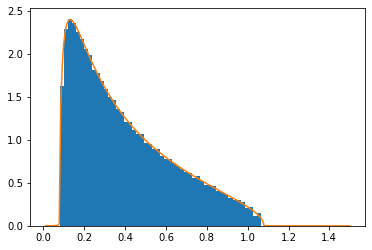

In [63]:
phi=1; psi=5; sx=1.; sw=1.; sb=.0; 
vx=sx**2.; vw=sw**2.; vb=sb**2.; 
f=np.tanh
chi=phi/psi
t1=theta1(f,vw,vx,vb)
t1b=theta1b(f,vw,vx,vb)
df=lambda x: derivative(f,x,dx=1e-5)
t2=theta2(df,vw,vx,vb)

n1=3000; n0=int(psi*n1); m=int(n0/phi);
xs=np.linspace(.01,1.5,200)
ys=np.array([np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True)) for x in xs])
rhosNB=np.max([chi,1])*ys.max(axis=1)/np.pi
bins=np.linspace(0,1.2,41)

NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=1,sigmax=sx,sigmaw=sw,sigmab=sb,batchNorm=False)
histNB=np.histogram(NN.eigs,bins,density=True)[0]
plt.hist(NN.eigs,50,density=True)
plt.plot(xs,rhosNB)
plt.show()

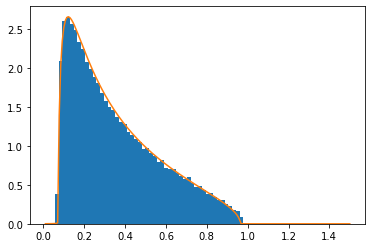

In [64]:
phi=1; psi=5; sx=1.; sw=1.; sb=.5; 
vx=sx**2.; vw=sw**2.; vb=sb**2.;
f=np.tanh
chi=phi/psi
t1=theta1(f,vw,vx,vb)
t1b=theta1b(f,vw,vx,vb)
df=lambda x: derivative(f,x,dx=1e-5)
t2=theta2(df,vw,vx,vb)

n1=3000; n0=int(psi*n1); m=int(n0/phi);
xs=np.linspace(.01,1.5,200)
ys=np.array([np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True)) for x in xs])
rhosB=np.max([chi,1])*ys.max(axis=1)/np.pi
bins=np.linspace(0,1.2,41)

NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=1,sigmax=sx,sigmaw=sw,sigmab=sb,batchNorm=False)
histB=np.histogram(NN.eigs[:-1],bins,density=True)[0]
plt.hist(NN.eigs[:-1],50,density=True)
plt.plot(xs,rhosB)
plt.show()

In [65]:
np.savetxt("hist_tanh.csv",np.array([(bins[1:]+bins[:-1])/2,histNB,histB]).T,delimiter=",")
np.savetxt("curve_tanh.csv",np.array([xs,rhos,rhosB]).T,delimiter=",")

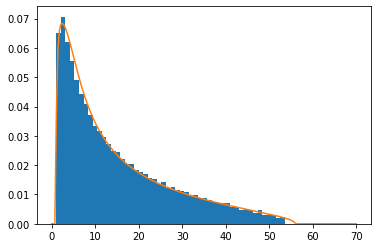

In [66]:
phi=1; psi=2; sx=1.; sw=1.; sb=.0; 
vx=sx**2.; vw=sw**2.; vb=sb**2.; 
f=lambda x:x**3
chi=phi/psi
t1=theta1(f,vw,vx,vb)
t1b=theta1b(f,vw,vx,vb)
df=lambda x: derivative(f,x,dx=1e-5)
t2=theta2(df,vw,vx,vb)

n1=3000; n0=int(psi*n1); m=int(n0/phi);
xs=np.linspace(.01,70,200)
ys=np.array([np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True)) for x in xs])
rhosNB=np.max([chi,1])*ys.max(axis=1)/np.pi
bins=np.linspace(0,80,41)

NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=1,sigmax=sx,sigmaw=sw,sigmab=sb,batchNorm=False)
histNB=np.histogram(NN.eigs,bins,density=True)[0]
plt.hist(NN.eigs,50,density=True)
plt.plot(xs,rhosNB)
plt.show()

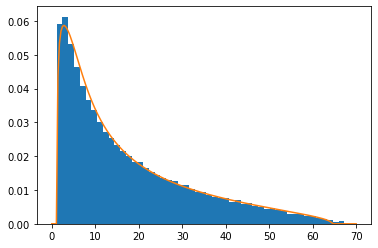

In [67]:
phi=1; psi=2; sx=1.; sw=1.; sb=.25; 
vx=sx**2.; vw=sw**2.; vb=sb**2.; 
f=lambda x:x**3
chi=phi/psi
t1=theta1(f,vw,vx,vb)
t1b=theta1b(f,vw,vx,vb)
df=lambda x: derivative(f,x,dx=1e-5)
t2=theta2(df,vw,vx,vb)

n1=3000; n0=int(psi*n1); m=int(n0/phi);
xs=np.linspace(.01,70,200)
ys=np.array([np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True)) for x in xs])
rhosB=np.max([chi,1])*ys.max(axis=1)/np.pi
bins=np.linspace(0,80,41)

NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=1,sigmax=sx,sigmaw=sw,sigmab=sb,batchNorm=False)
histB=np.histogram(NN.eigs[:-1],bins,density=True)[0]
plt.hist(NN.eigs[:-1],50,density=True)
plt.plot(xs,rhosB)
plt.show()

In [68]:
np.savetxt("hist_cube.csv",np.array([(bins[1:]+bins[:-1])/2,histNB,histB]).T,delimiter=",")
np.savetxt("curve_cube.csv",np.array([xs,rhos,rhosB]).T,delimiter=",")

## Figure 2

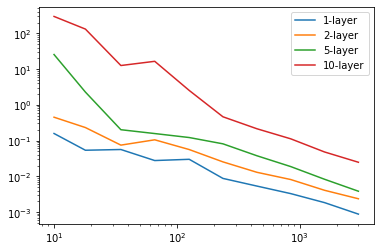

In [69]:
phi=1;psi=2;sx=1.;sw=1.;sb=.0
chi=phi/psi
vx=sx**2.; vw=sw**2.; vb=sb**2.; 
layers=[1,2,5,10]
ns=np.logspace(1,np.log10(3000),10).astype(int)
result = {}
alpha=1
xs=np.linspace(0,6,3000)
dx=xs[1]-xs[0]

t1=theta1(falpha(1),vw,vx,vb)
t1b=theta1b(falpha(alpha),vw,vx,vb)
df=lambda x: derivative(falpha(alpha),x,dx=1e-5)
t2=theta2(df,vw,vx,vb)
ys=np.array([np.max(np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True))) for x in xs])
rhos=np.max([chi,1])*ys/np.pi

for n1 in ns:
    print(n1)
    n0=int(psi*n1)
    m=int(n0/phi)
    for i in layers:
        Ys = multiLayerNLRM(n0,n1,m,cplx=False,f=falpha(alpha),layers=i,sigmax=sx,sigmaw=sw,sigmab=sb)
        Yeigs=Ys.eigs.flatten()
        result[i,n1] = stats.wasserstein_distance(Yeigs,xs,v_weights=rhos) #np.max(np.abs([np.mean(Yeigs<=xmax)for xmax in xs]-np.cumsum(rhos*dx) ))
clear_output()

for i in layers:
    plt.loglog(ns,[result[i,n] for n in ns],label="{}-layer".format(i))
plt.legend()
plt.show()
np.savetxt("wasserstein_no_bias.csv",np.array([ns]+[[result[i,n] for n in ns] for i in layers]).T,delimiter=",")

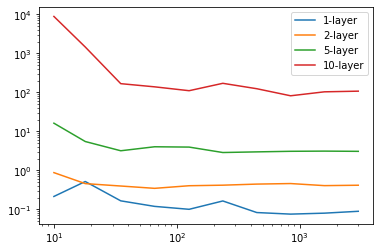

In [70]:
phi=1;psi=2;sx=1.;sw=1.;sb=.5
chi=phi/psi
vx=sx**2.; vw=sw**2.; vb=sb**2.; 
layers=[1,2,5,10]
ns=np.logspace(1,np.log10(3000),10).astype(int)
result = {}
alpha=1
xs=np.linspace(0,6,3000)
dx=xs[1]-xs[0]

t1=theta1(falpha(1),vw,vx,vb)
t1b=theta1b(falpha(alpha),vw,vx,vb)
df=lambda x: derivative(falpha(alpha),x,dx=1e-5)
t2=theta2(df,vw,vx,vb)
ys=np.array([np.max(np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True))) for x in xs])
rhos=np.max([chi,1])*ys/np.pi

for n1 in ns:
    print(n1)
    n0=int(psi*n1)
    m=int(n0/phi)
    for i in layers:
        Ys = multiLayerNLRM(n0,n1,m,cplx=False,f=falpha(alpha),layers=i,sigmax=sx,sigmaw=sw,sigmab=sb)
        Yeigs=Ys.eigs.flatten()
        result[i,n1] = stats.wasserstein_distance(Yeigs,xs,v_weights=rhos) #np.max(np.abs([np.mean(Yeigs<=xmax)for xmax in xs]-np.cumsum(rhos*dx) ))
clear_output()

for i in layers:
    plt.loglog(ns,[result[i,n] for n in ns],label="{}-layer".format(i))
plt.legend()
plt.show()
np.savetxt("wasserstein_bias.csv",np.array([ns]+[[result[i,n] for n in ns] for i in layers]).T,delimiter=",")

## Figure 3

In [72]:
phi=1; psi=2; sx=1.; sw=1.; sb=.5; alpha=1
vx=sx**2.; vw=sw**2.; vb=sb**2.; 
f=falpha(alpha)
chi=phi/psi
t1=theta1(f,vw,vx,vb)
t1b=theta1b(f,vw,vx,vb)
df=lambda x: derivative(f,x,dx=1e-5)
t2=theta2(df,vw,vx,vb)
xs=np.linspace(0,5,200)
ys=np.array([np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True)) for x in xs])
rhos=np.max([chi,1])*ys.max(axis=1)/np.pi
np.savetxt("f1_curve_bias.csv",np.array([xs,rhos]).T,delimiter=",")

In [73]:
phi=1; psi=2; sx=1.; sw=1.; sb=0; alpha=1
vx=sx**2.; vw=sw**2.; vb=sb**2.; 
f=falpha(alpha)
chi=phi/psi
t1=theta1(f,vw,vx,vb)
t1b=theta1b(f,vw,vx,vb)
df=lambda x: derivative(f,x,dx=1e-5)
t2=theta2(df,vw,vx,vb)
xs=np.linspace(0,5,200)
ys=np.array([np.imag(gcomp(x+.0001j,t1-t1b,t2,phi,psi,cubic=True)) for x in xs])
rhos=np.max([chi,1])*ys.max(axis=1)/np.pi
np.savetxt("f1_curve_bias.csv",np.array([xs,rhos]).T,delimiter=",")

In [74]:
layers=[1,2,5]
n1=3000
n0=int(psi*n1)
m=int(n0/phi)

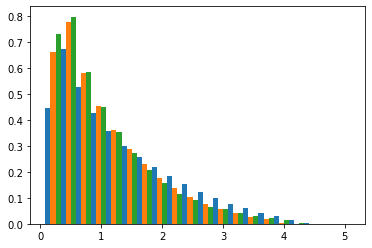

In [90]:
hists=[]
bins=np.linspace(0,5,21)
hists.append((bins[1:]+bins[:-1])/2)
for i in layers:
    NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=i,sigmax=sx,sigmaw=sw,sigmab=.5,batchNorm=True)
    hists.append(np.histogram(NN.eigs[:-1],bins,density=True)[0])
for (i,k) in enumerate(layers):
    plt.bar(hists[0]+i*(bins[1]-bins[0])/3,hists[i+1],width=(bins[1]-bins[0])/3)
plt.show()
np.savetxt("hists_batch_bias.csv",np.array(hists).T,delimiter=",")

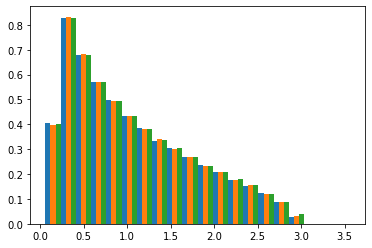

In [87]:
hists=[]
bins=np.linspace(0,3.5,21)
hists.append((bins[1:]+bins[:-1])/2)
for i in layers:
    NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=i,sigmax=sx,sigmaw=sw,sigmab=0,batchNorm=False)
    hists.append(np.histogram(NN.eigs[:-1],bins,density=True)[0])
for (i,k) in enumerate(layers):
    plt.bar(hists[0]+i*(bins[1]-bins[0])/3,hists[i+1],width=(bins[1]-bins[0])/3)
plt.show()
np.savetxt("hists_nobatch_nobias.csv",np.array(hists).T,delimiter=",")

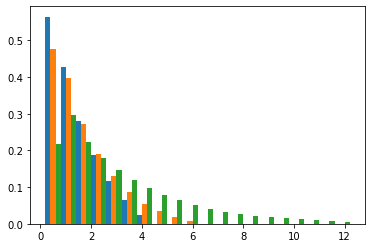

In [88]:
hists=[]
bins=np.linspace(0,12,21)
hists.append((bins[1:]+bins[:-1])/2)
for i in layers:
    NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=i,sigmax=sx,sigmaw=sw,sigmab=.5,batchNorm=False)
    hists.append(np.histogram(NN.eigs[:-1],bins,density=True)[0])
for (i,k) in enumerate(layers):
    plt.bar(hists[0]+i*(bins[1]-bins[0])/3,hists[i+1],width=(bins[1]-bins[0])/3)
plt.show()
np.savetxt("hists_nobatch_bias.csv",np.array(hists).T,delimiter=",")

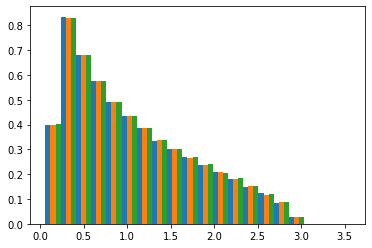

In [89]:
hists=[]
bins=np.linspace(0,3.5,21)
hists.append((bins[1:]+bins[:-1])/2)
for i in layers:
    NN=multiLayerNLRM(n0,n1,m,cplx=False,f=f,layers=i,sigmax=sx,sigmaw=sw,sigmab=0,batchNorm=True)
    hists.append(np.histogram(NN.eigs[:-1],bins,density=True)[0])
for (i,k) in enumerate(layers):
    plt.bar(hists[0]+i*(bins[1]-bins[0])/3,hists[i+1],width=(bins[1]-bins[0])/3)
plt.show()
np.savetxt("hists_batch_nobias.csv",np.array(hists).T,delimiter=",")